In [1]:
# ==========================================
# BLOCK 1: IMPORTS & CONFIGURATION
# ==========================================
import os
import shutil
import zipfile
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import files
import datetime

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

# --- Configuration ---
# Detect if we have a GPU available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {DEVICE}")

# Hyperparameters & Constants
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Resize all images to this standard size
SEED = 42
torch.manual_seed(SEED)

# Paths
MERGED_DIR = "./merged_dataset" # Where we will combine all images

✅ Device set to: cuda


In [2]:
# ==========================================
# BLOCK 2: DOWNLOAD & UNZIP DATA
# ==========================================
from zipfile import ZipFile

# 1. Install Kaggle
!pip install -q kaggle

# 2. Set your credentials (PLEASE FILL THESE IN)
os.environ['KAGGLE_USERNAME'] = "shaguns26"
os.environ['KAGGLE_KEY'] = ""

# 3. Download the datasets
print("Downloading Datasets...")
#!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!kaggle datasets download -d abdulahad0296/indoor-plant-disease-detection-dataset

# 4. Unzip the files
print("Unzipping Datasets...")
#!unzip -q plantvillage-dataset.zip
!unzip -q indoor-plant-disease-detection-dataset.zip

# 5. Verify it worked
print("✅ files downloaded and unzipped. Current directory:")
!ls

Dataset URL: https://www.kaggle.com/datasets/abdulahad0296/indoor-plant-disease-detection-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.18G/2.19G [00:22<00:00, 215MB/s]
100% 2.19G/2.19G [00:22<00:00, 104MB/s]
Unzipping Datasets...
✅ files downloaded and unzipped. Current directory:
indoor	indoor-plant-disease-detection-dataset.zip  sample_data


In [3]:
# ==========================================
# BLOCK 3: FILTER & MERGE DATASETS
# ==========================================
def merge_and_filter_datasets():
    # 1. Define the whitelist & renaming logic
    target_classes = {
        # # --- PlantVillage ---
        # 'Apple___Black_rot': 'Apple__Black_Rot',
        # 'Apple___healthy': 'Apple__Healthy',
        # 'Apple___Apple_scab': 'Apple__Scab',
        # 'Apple___Cedar_apple_rust': 'Apple__Rust',
        # 'Cherry_(including_sour)___Powdery_mildew': 'Cherry__Powdery_Mildew',
        # 'Cherry_(including_sour)___healthy': 'Cherry__Healthy',
        # 'Pepper,_bell___Bacterial_spot': 'Pepper__Bacterial_Spot',
        # 'Pepper,_bell___healthy': 'Pepper__Healthy',
        # 'Strawberry___Leaf_scorch': 'Strawberry__Scorch',
        # 'Strawberry___healthy': 'Strawberry__Healthy',
        # 'Tomato___Early_blight': 'Tomato__Early_Blight',
        # 'Tomato___Late_blight': 'Tomato__Late_Blight',
        # 'Tomato___healthy': 'Tomato__Healthy',

        # --- Indoor Plants ---
        # 'Aloe_Anthracnose': 'Aloe_Vera__Anthracnose',
        # 'Aloe_Healthy': 'Aloe_Vera__Healthy',
        # 'Aloe_LeafSpot': 'Aloe_Vera__LeafSpot',
        # 'Aloe_Rust': 'Aloe_Vera__Rust',
        # 'Aloe_Sunburn': 'Aloe_Vera__Sunburn',
        # 'Cactus_Dactylopius_Opuntia': 'Cactus__Dactylopius_Opuntia',
        # 'Cactus_Healthy': 'Cactus__Healthy',
        'Money_Plant_Bacterial_wilt_disease': 'Money_Plant__Bacterial_wilt_disease',
        'Money_Plant_Healthy': 'Money_Plant__Healthy',
        'Money_Plant_Manganese_Toxicity': 'Money_Plant__Manganese_Toxicity',
        'Snake_Plant_Anthracnose': 'Snake_Plant__Anthracnose',
        'Snake_Plant_Healthy': 'Snake_Plant__Healthy',
        'Snake_Plant_Leaf_Withering': 'Snake_Plant__Leaf_Withering',
        'Spider_Plant_Fungal_leaf_spot': 'Spider_Plant__Fungal_leaf_spot',
        'Spider_Plant_Healthy': 'Spider_Plant__Healthy',
        'Spider_Plant_Leaf_Tip_Necrosis': 'Spider_Plant__Leaf_Tip_Necrosis',
    }

    # 2. Reset the merged directory
    if os.path.exists(MERGED_DIR):
        shutil.rmtree(MERGED_DIR)
    os.makedirs(MERGED_DIR)

    print(f"Filtering datasets...")

    count = 0
    # Walk through the current directory to find raw class folders
    for root, dirs, _ in os.walk("."):
        # Skip the output folder and hidden system folders
        if "merged_dataset" in root or ".git" in root:
            continue

        for d in dirs:
            # CHECK: Is this folder in our target list?
            if d in target_classes:
                # Logic: Found a match!
                original_path = os.path.join(root, d)
                new_name = target_classes[d]
                dest_path = os.path.join(MERGED_DIR, new_name)

                # Copy logic
                if not os.path.exists(dest_path):
                    shutil.copytree(original_path, dest_path)
                    count += 1
                else:
                    # If folder exists (rare overlap), merge files
                    for file in os.listdir(original_path):
                        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                            shutil.copy2(os.path.join(original_path, file), os.path.join(dest_path, file))

                print(f"  -> Merged: {d}  ==>  {new_name}")

    print(f"\n✅ Successfully filtered & merged {count} classes into '{MERGED_DIR}'")

# Run the new logic
merge_and_filter_datasets()

Filtering datasets...
  -> Merged: Snake_Plant_Anthracnose  ==>  Snake_Plant__Anthracnose
  -> Merged: Spider_Plant_Fungal_leaf_spot  ==>  Spider_Plant__Fungal_leaf_spot
  -> Merged: Snake_Plant_Leaf_Withering  ==>  Snake_Plant__Leaf_Withering
  -> Merged: Snake_Plant_Healthy  ==>  Snake_Plant__Healthy
  -> Merged: Spider_Plant_Leaf_Tip_Necrosis  ==>  Spider_Plant__Leaf_Tip_Necrosis
  -> Merged: Money_Plant_Bacterial_wilt_disease  ==>  Money_Plant__Bacterial_wilt_disease
  -> Merged: Spider_Plant_Healthy  ==>  Spider_Plant__Healthy
  -> Merged: Money_Plant_Manganese_Toxicity  ==>  Money_Plant__Manganese_Toxicity
  -> Merged: Money_Plant_Healthy  ==>  Money_Plant__Healthy
  -> Merged: Snake_Plant_Anthracnose  ==>  Snake_Plant__Anthracnose
  -> Merged: Spider_Plant_Fungal_leaf_spot  ==>  Spider_Plant__Fungal_leaf_spot
  -> Merged: Snake_Plant_Leaf_Withering  ==>  Snake_Plant__Leaf_Withering
  -> Merged: Snake_Plant_Healthy  ==>  Snake_Plant__Healthy
  -> Merged: Spider_Plant_Leaf_Tip_Nec

In [4]:
# ==========================================
# BLOCK 4: DATA LOADING & TRANSFORMS
# ==========================================
def get_data_loaders(data_dir, batch_size):
    # Standardize images: Resize -> Tensor -> Normalize
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        full_dataset = datasets.ImageFolder(data_dir, transform=transform)
    except FileNotFoundError:
        print("❌ Error: Merged dataset folder not found. Did Block 3 run?")
        return None, None, []

    # Split 80% Train, 20% Validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, full_dataset.classes

# Initialize Loaders
train_loader, val_loader, class_names = get_data_loaders(MERGED_DIR, BATCH_SIZE)
print(f"Classes Found: {len(class_names)}")

Classes Found: 9


In [5]:
# ==========================================
# BLOCK 5: CUSTOM CNN ARCHITECTURE
# ==========================================
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()

        # Block 1: Conv -> ReLU -> Pool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Flatten Dimension Calculation:
        # Input 128x128 -> Pool(2) -> 64 -> Pool(2) -> 32 -> Pool(2) -> 16
        # Final shape: 128 channels * 16 * 16
        self.flatten_dim = 128 * 16 * 16

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.dropout = nn.Dropout(0.5) # Prevents overfitting
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, self.flatten_dim) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# ==========================================
# BLOCK 6: FIXED TRAINING ENGINE
# ==========================================
import copy
import time

def train_engine(model, train_loader, val_loader, criterion, optimizer, epochs, patience=3, model_name="Model"):
    print(f"\n--- Training {model_name} (Max Epochs: {epochs}, Patience: {patience}) ---")

    # Track metrics (Now includes BOTH Accuracy and MER)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_mer': [], 'val_mer': [],  # Error Rates
        'val_acc': [],                   # Accuracy (Needed for Grid Search)
        'stop_epoch': None
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        train_mer = 100 - train_acc

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_mer = 100 - val_acc

        # Store history (ALL keys included now)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_mer'].append(train_mer)
        history['val_mer'].append(val_mer)
        history['val_acc'].append(val_acc) # <--- This was missing!

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}%")

        # --- Early Stopping Logic ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early Stopping triggered at Epoch {epoch+1}!")
                history['stop_epoch'] = epoch + 1
                break

    if history['stop_epoch'] is None:
        history['stop_epoch'] = epochs

    model.load_state_dict(best_model_wts)
    print(f"✅ Training Complete. Best Validation Loss: {best_val_loss:.4f}")

    return history

In [7]:
# ==========================================
# BLOCK 6.5: EVALUATION FUNCTION (ACCURACY & VISUALS)
# ==========================================
def evaluate_model_performance(model, loader, classes, model_name="Model"):
    print(f"\n📊 EVALUATION REPORT: {model_name}")
    print("-" * 40)

    model.eval()
    correct = 0
    total = 0

    # Dictionary to store one example per class: {class_name: (image, pred_idx, true_idx)}
    class_examples = {}

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect one example for every class found in this batch
            for i in range(len(labels)):
                label_idx = labels[i].item()
                class_name = classes[label_idx]

                # Only save if we haven't seen this class yet
                if class_name not in class_examples:
                    class_examples[class_name] = (images[i].cpu(), predicted[i].item(), label_idx)

            # Optional: Stop early if we found all classes (saves time)
            if len(class_examples) == len(classes):
                break

    # 1. Check Accuracy
    accuracy = 100 * correct / total
    print(f"✅ Final Test Accuracy: {accuracy:.2f}%")

    # 2. Visual Predictions (One Per Class)
    print(f"\n🖼️ Visual Predictions (One Example Per Class):")

    # Sort classes alphabetically for clean display
    sorted_classes = sorted(class_examples.keys())

    # Dynamic Grid Calculation
    cols = 5
    rows = (len(sorted_classes) + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for idx, class_name in enumerate(sorted_classes):
        img_tensor, pred_idx, true_idx = class_examples[class_name]

        # Un-normalize for display (Tensor -> Image)
        img = img_tensor.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        ax = plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)

        # Green title = Correct, Red title = Wrong
        is_correct = (pred_idx == true_idx)
        color = 'green' if is_correct else 'red'

        # Show Prediction vs Truth
        title_text = f"True: {class_name}\nPred: {classes[pred_idx]}"
        plt.title(title_text, color=color, fontsize=9, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    return accuracy

In [12]:
# ==========================================
# BLOCK 7: TRAIN MODEL 1 (BASELINE)
# ==========================================
# Initialize
model_1 = PlantDiseaseCNN(num_classes=len(class_names)).to(DEVICE)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)

# Train with Early Stopping (e.g., max 20 epochs, patience 3)
history_1 = train_engine(model_1, train_loader, val_loader, criterion, optimizer_1, epochs=20, patience=3, model_name="Model 1 (Baseline)")

# 4. Save
torch.save(model_1.state_dict(), "model_1_baseline.pth")
print("✅ Model 1 Saved.")
files.download("model_1_baseline.pth")


--- Training Model 1 (Baseline) (Max Epochs: 20, Patience: 3) ---
Epoch [1/20] Train Loss: 1.8342 | Val Loss: 1.5188 | Val Acc: 37.47%
Epoch [2/20] Train Loss: 1.2997 | Val Loss: 1.2621 | Val Acc: 52.89%
Epoch [3/20] Train Loss: 1.0785 | Val Loss: 1.0449 | Val Acc: 59.23%
Epoch [4/20] Train Loss: 0.8778 | Val Loss: 0.8802 | Val Acc: 63.36%
Epoch [5/20] Train Loss: 0.7302 | Val Loss: 0.8088 | Val Acc: 70.80%
Epoch [6/20] Train Loss: 0.6068 | Val Loss: 0.8041 | Val Acc: 69.15%
Epoch [7/20] Train Loss: 0.5547 | Val Loss: 0.7515 | Val Acc: 68.04%
Epoch [8/20] Train Loss: 0.4360 | Val Loss: 0.9214 | Val Acc: 68.87%
Epoch [9/20] Train Loss: 0.3681 | Val Loss: 0.7243 | Val Acc: 71.90%
Epoch [10/20] Train Loss: 0.2596 | Val Loss: 0.8110 | Val Acc: 71.35%
Epoch [11/20] Train Loss: 0.2692 | Val Loss: 0.9043 | Val Acc: 69.70%
Epoch [12/20] Train Loss: 0.2082 | Val Loss: 0.8429 | Val Acc: 70.80%
🛑 Early Stopping triggered at Epoch 12!
✅ Training Complete. Best Validation Loss: 0.7243
✅ Model 1 Sa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

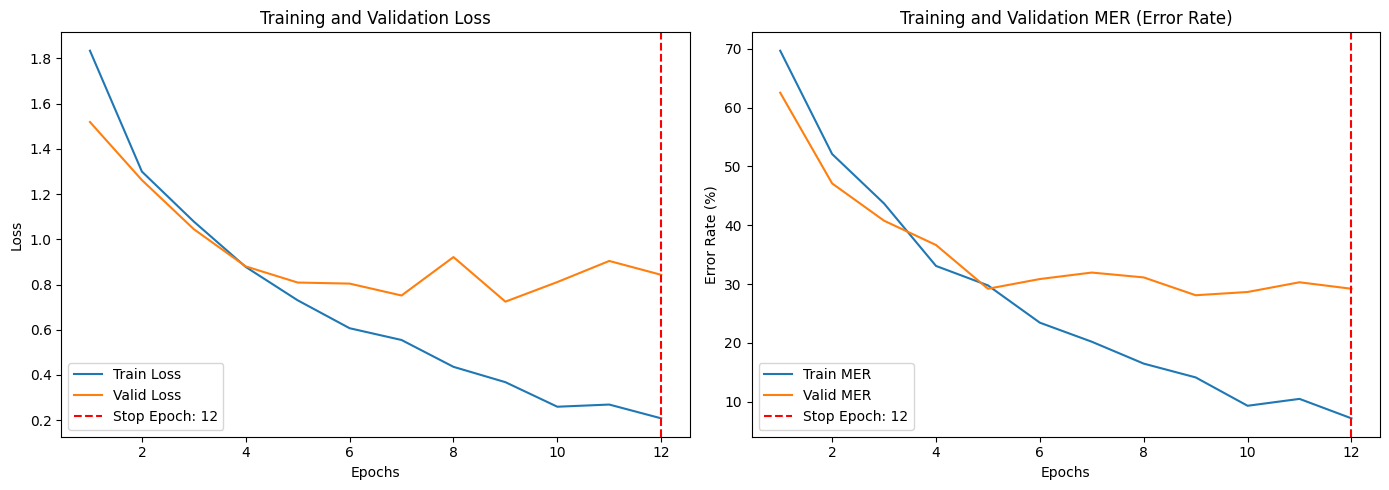

In [13]:
# ==========================================
# BLOCK 7 pt2: PLOTTING METRICS
# ==========================================
def plot_training_metrics(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    stop_epoch = history['stop_epoch']

    plt.figure(figsize=(14, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Valid Loss')
    plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Stop Epoch: {stop_epoch}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot 2: MER (Misclassification Error Rate)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_mer'], label='Train MER')
    plt.plot(epochs_range, history['val_mer'], label='Valid MER')
    plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Stop Epoch: {stop_epoch}')
    plt.title('Training and Validation MER (Error Rate)')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(history_1)

In [14]:
# ==========================================
# BLOCK 7 pt3: TEST RMSE & MAE
# ==========================================
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_regression_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    # Note: Treating categorical class indices as continuous values
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = mean_absolute_error(all_labels, all_preds)

    print("\n📊 TEST METRICS (on Validation Set)")
    print("-" * 30)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE:  {mae:.4f}")
    print("-" * 30)

calculate_regression_metrics(model_1, val_loader)


📊 TEST METRICS (on Validation Set)
------------------------------
Test RMSE: 0.8249
Test MAE:  0.3884
------------------------------


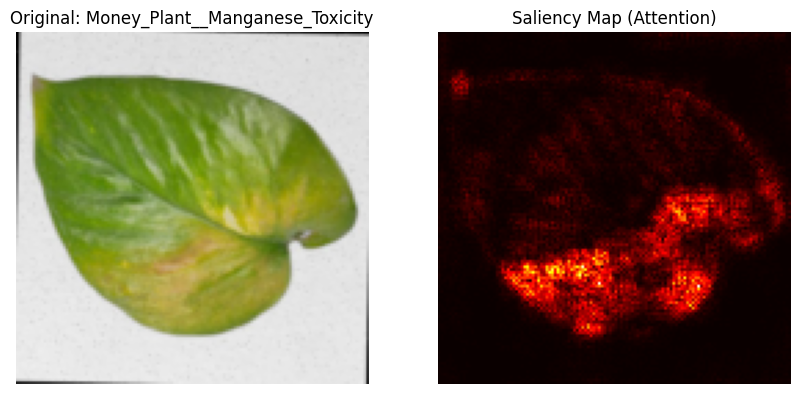

Generating t-SNE plot (Latent Space)...


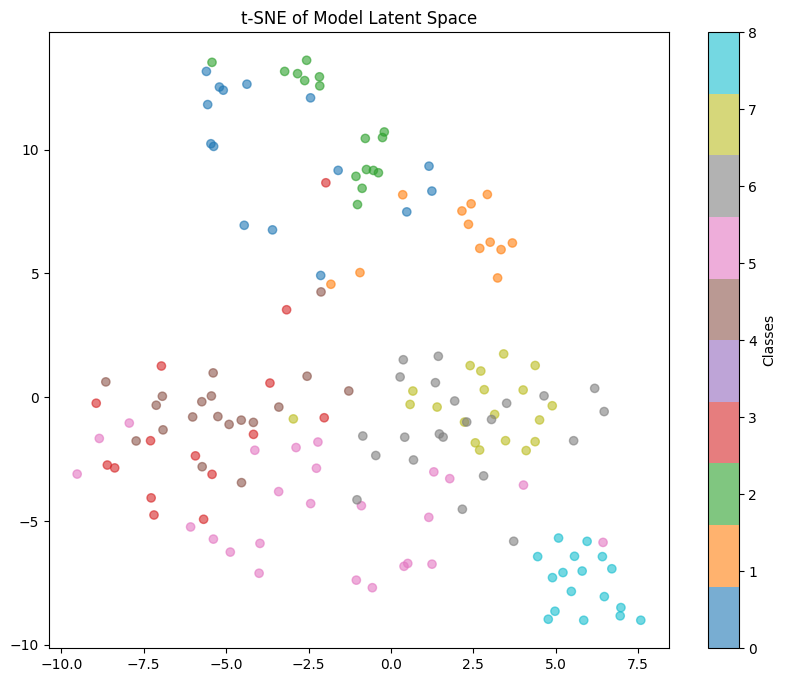

In [15]:
# ==========================================
# BLOCK 7 pt 4: FEEDBACK VISUALIZATIONS
# ==========================================
from sklearn.manifold import TSNE

# 1. Saliency Map (What is the model looking at?)
def visualize_saliency(model, loader):
    model.eval()
    # Get one batch
    images, labels = next(iter(loader))
    img = images[0].unsqueeze(0).to(DEVICE)
    img.requires_grad_() # Need gradients

    output = model(img)
    score, prediction = torch.max(output, 1)
    score.backward() # Backprop to image

    # Saliency is max absolute gradient across channels
    saliency, _ = torch.max(img.grad.data.abs(), dim=1)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # Un-normalize for display
    disp_img = img[0].detach().cpu().permute(1, 2, 0)
    disp_img = disp_img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    plt.imshow(torch.clamp(disp_img, 0, 1))
    plt.title(f"Original: {class_names[labels[0]]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0].cpu(), cmap='hot')
    plt.title("Saliency Map (Attention)")
    plt.axis('off')
    plt.show()

# 2. t-SNE (Latent Space Clusters)
def visualize_tsne(model, loader, batches=5):
    print("Generating t-SNE plot (Latent Space)...")
    model.eval()
    features = []
    targets = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            if i >= batches: break
            images = images.to(DEVICE)

            # Run part of the model (Up to FC1)
            x = model.pool(F.relu(model.conv1(images)))
            x = model.pool(F.relu(model.conv2(x)))
            x = model.pool(F.relu(model.conv3(x)))
            x = x.view(-1, model.flatten_dim)
            x = F.relu(model.fc1(x)) # Stop here

            features.append(x.cpu().numpy())
            targets.append(labels.cpu().numpy())

    features = np.concatenate(features)
    targets = np.concatenate(targets)

    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=targets, cmap='tab10', alpha=0.6)
    plt.title("t-SNE of Model Latent Space")
    plt.colorbar(scatter, label="Classes")
    plt.show()

# Run them
visualize_saliency(model_1, val_loader)
visualize_tsne(model_1, val_loader)


--- Starting Grid Search ---

Testing: LR=0.001, Batch Size=32

--- Training GridSearch_0.001_32 (Max Epochs: 20, Patience: 3) ---
Epoch [1/20] Train Loss: 1.8274 | Val Loss: 1.4078 | Val Acc: 41.87%
Epoch [2/20] Train Loss: 1.2477 | Val Loss: 1.1397 | Val Acc: 53.17%
Epoch [3/20] Train Loss: 0.9848 | Val Loss: 0.9870 | Val Acc: 57.85%
Epoch [4/20] Train Loss: 0.7991 | Val Loss: 0.8430 | Val Acc: 66.94%
Epoch [5/20] Train Loss: 0.6138 | Val Loss: 0.8531 | Val Acc: 65.56%
Epoch [6/20] Train Loss: 0.5044 | Val Loss: 0.8622 | Val Acc: 69.42%
Epoch [7/20] Train Loss: 0.3997 | Val Loss: 0.8413 | Val Acc: 69.42%
Epoch [8/20] Train Loss: 0.3769 | Val Loss: 0.8626 | Val Acc: 70.52%
Epoch [9/20] Train Loss: 0.2941 | Val Loss: 0.8688 | Val Acc: 72.45%
Epoch [10/20] Train Loss: 0.2151 | Val Loss: 0.9136 | Val Acc: 69.15%
🛑 Early Stopping triggered at Epoch 10!
✅ Training Complete. Best Validation Loss: 0.8413

Testing: LR=0.001, Batch Size=64

--- Training GridSearch_0.001_64 (Max Epochs: 20, Pa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🏆 Analyzing Best Optimized Model (Params: {'lr': 0.001, 'batch_size': 64})...

📊 EVALUATION REPORT: Model 2 (Optimized)
----------------------------------------
✅ Final Test Accuracy: 93.75%

🖼️ Visual Predictions (One Example Per Class):


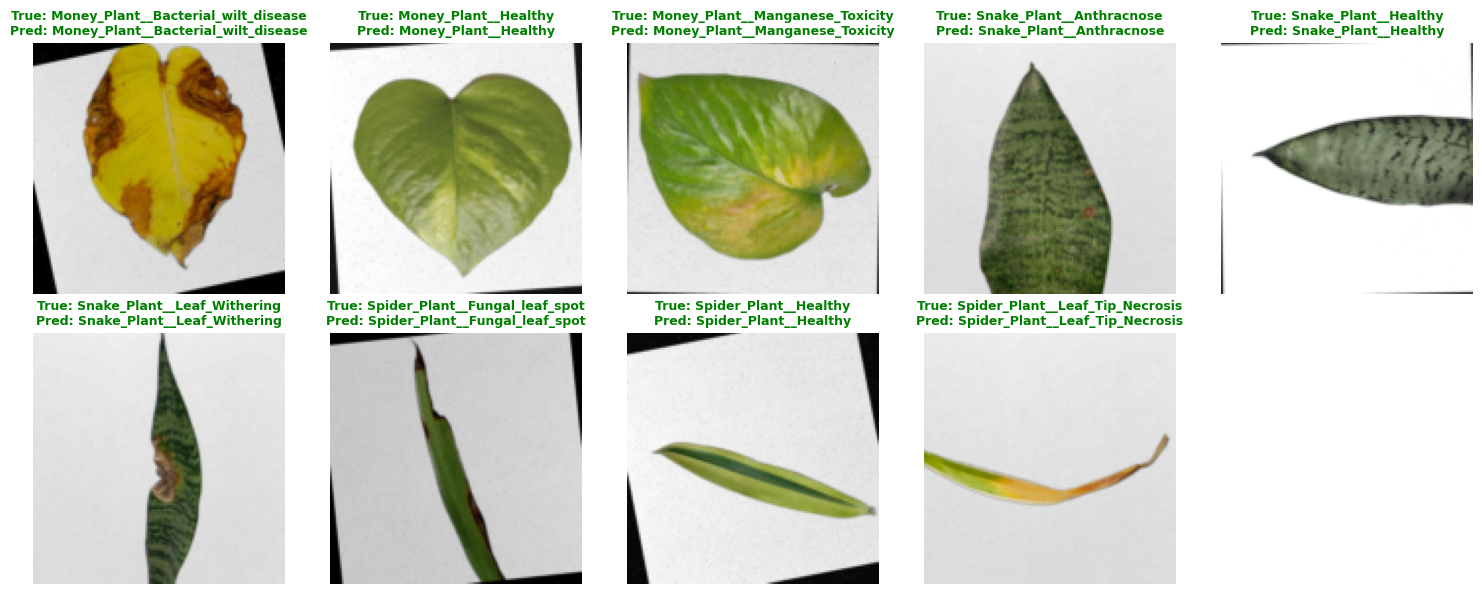

In [18]:
# ==========================================
# BLOCK 8: GRID SEARCH (MODEL 2 OPTIMIZATION)
# ==========================================
def custom_grid_search():
    # We will try 2 learning rates and 2 batch sizes
    lrs = [0.001, 0.0001]
    batch_sizes = [32, 64]

    best_acc = 0
    best_params = {}
    best_model_state = None

    print("\n--- Starting Grid Search ---")

    for lr in lrs:
        for bs in batch_sizes:
            print(f"\nTesting: LR={lr}, Batch Size={bs}")

            # Re-initialize loaders for batch size change
            t_loader, v_loader, _ = get_data_loaders(MERGED_DIR, bs)

            # Initialize fresh model
            temp_model = PlantDiseaseCNN(len(class_names)).to(DEVICE)
            temp_opt = optim.Adam(temp_model.parameters(), lr=lr)

            # Short training (3 epochs) to test settings
            hist = train_engine(temp_model, t_loader, v_loader, criterion, temp_opt, epochs=20, model_name=f"GridSearch_{lr}_{bs}")

            final_acc = hist['val_acc'][-1]

            if final_acc > best_acc:
                best_acc = final_acc
                best_params = {'lr': lr, 'batch_size': bs}
                best_model_state = temp_model.state_dict()

    print(f"\n✅ Best Params Found: {best_params} with Acc: {best_acc:.2f}%")
    return best_model_state, best_params, best_acc

criterion = nn.CrossEntropyLoss()

# Run Search
best_state, best_params, best_acc = custom_grid_search()

# Load best weights into Model 2
model_2 = PlantDiseaseCNN(len(class_names)).to(DEVICE)
model_2.load_state_dict(best_state)
torch.save(model_2.state_dict(), "model_2_optimized.pth")
files.download("model_2_optimized.pth")

# EVALUATE
print(f"\n🏆 Analyzing Best Optimized Model (Params: {best_params})...")
acc_2 = evaluate_model_performance(model_2, val_loader, class_names, "Model 2 (Optimized)")

In [11]:
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Classes: {len(class_names)}")

Training batches: 46
Validation batches: 12
Classes: 9


In [8]:
# ==========================================
# BLOCK 9: RESNET50 TRANSFER LEARNING
# ==========================================
def get_resnet_model(num_classes):
    print("Loading Pre-trained ResNet50...")
    # Use the new 'weights' parameter instead of 'pretrained=True' (deprecated)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # 1. Freeze all layers (save memory/gradients)
    for param in model.parameters():
        param.requires_grad = False

    # 2. Replace the final fully connected layer (The "Head")
    # ResNet50's fc layer has 2048 input features
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

# Initialize
criterion = nn.CrossEntropyLoss()
model_3 = get_resnet_model(len(class_names)).to(DEVICE)

# CRITICAL: Optimizer must only update the final layer (model.fc)
# If you try to update model.parameters(), it will error because others are frozen
optimizer_3 = optim.Adam(model_3.fc.parameters(), lr=0.001)

# Train using your updated engine
# Note: Transfer learning often converges faster, so 5-10 epochs is usually enough
history_3 = train_engine(model_3, train_loader, val_loader, criterion, optimizer_3, epochs=20, patience=3, model_name="Model 3 (ResNet)")

# Save
torch.save(model_3.state_dict(), "model_3_resnet.pth")


Loading Pre-trained ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]



--- Training Model 3 (ResNet) (Max Epochs: 20, Patience: 3) ---
Epoch [1/20] Train Loss: 1.5166 | Val Loss: 1.0075 | Val Acc: 84.30%
Epoch [2/20] Train Loss: 0.8071 | Val Loss: 0.6951 | Val Acc: 87.88%
Epoch [3/20] Train Loss: 0.5725 | Val Loss: 0.5451 | Val Acc: 88.98%
Epoch [4/20] Train Loss: 0.4329 | Val Loss: 0.4733 | Val Acc: 90.63%
Epoch [5/20] Train Loss: 0.3948 | Val Loss: 0.4229 | Val Acc: 90.63%
Epoch [6/20] Train Loss: 0.3129 | Val Loss: 0.4051 | Val Acc: 90.63%
Epoch [7/20] Train Loss: 0.2812 | Val Loss: 0.3644 | Val Acc: 92.01%
Epoch [8/20] Train Loss: 0.2512 | Val Loss: 0.3371 | Val Acc: 92.01%
Epoch [9/20] Train Loss: 0.2269 | Val Loss: 0.3347 | Val Acc: 93.39%
Epoch [10/20] Train Loss: 0.2026 | Val Loss: 0.3137 | Val Acc: 93.94%
Epoch [11/20] Train Loss: 0.1847 | Val Loss: 0.2897 | Val Acc: 93.11%
Epoch [12/20] Train Loss: 0.1606 | Val Loss: 0.2794 | Val Acc: 92.84%
Epoch [13/20] Train Loss: 0.1580 | Val Loss: 0.2701 | Val Acc: 93.11%
Epoch [14/20] Train Loss: 0.1440 |

Generating Confusion Matrix... (This might take a moment)


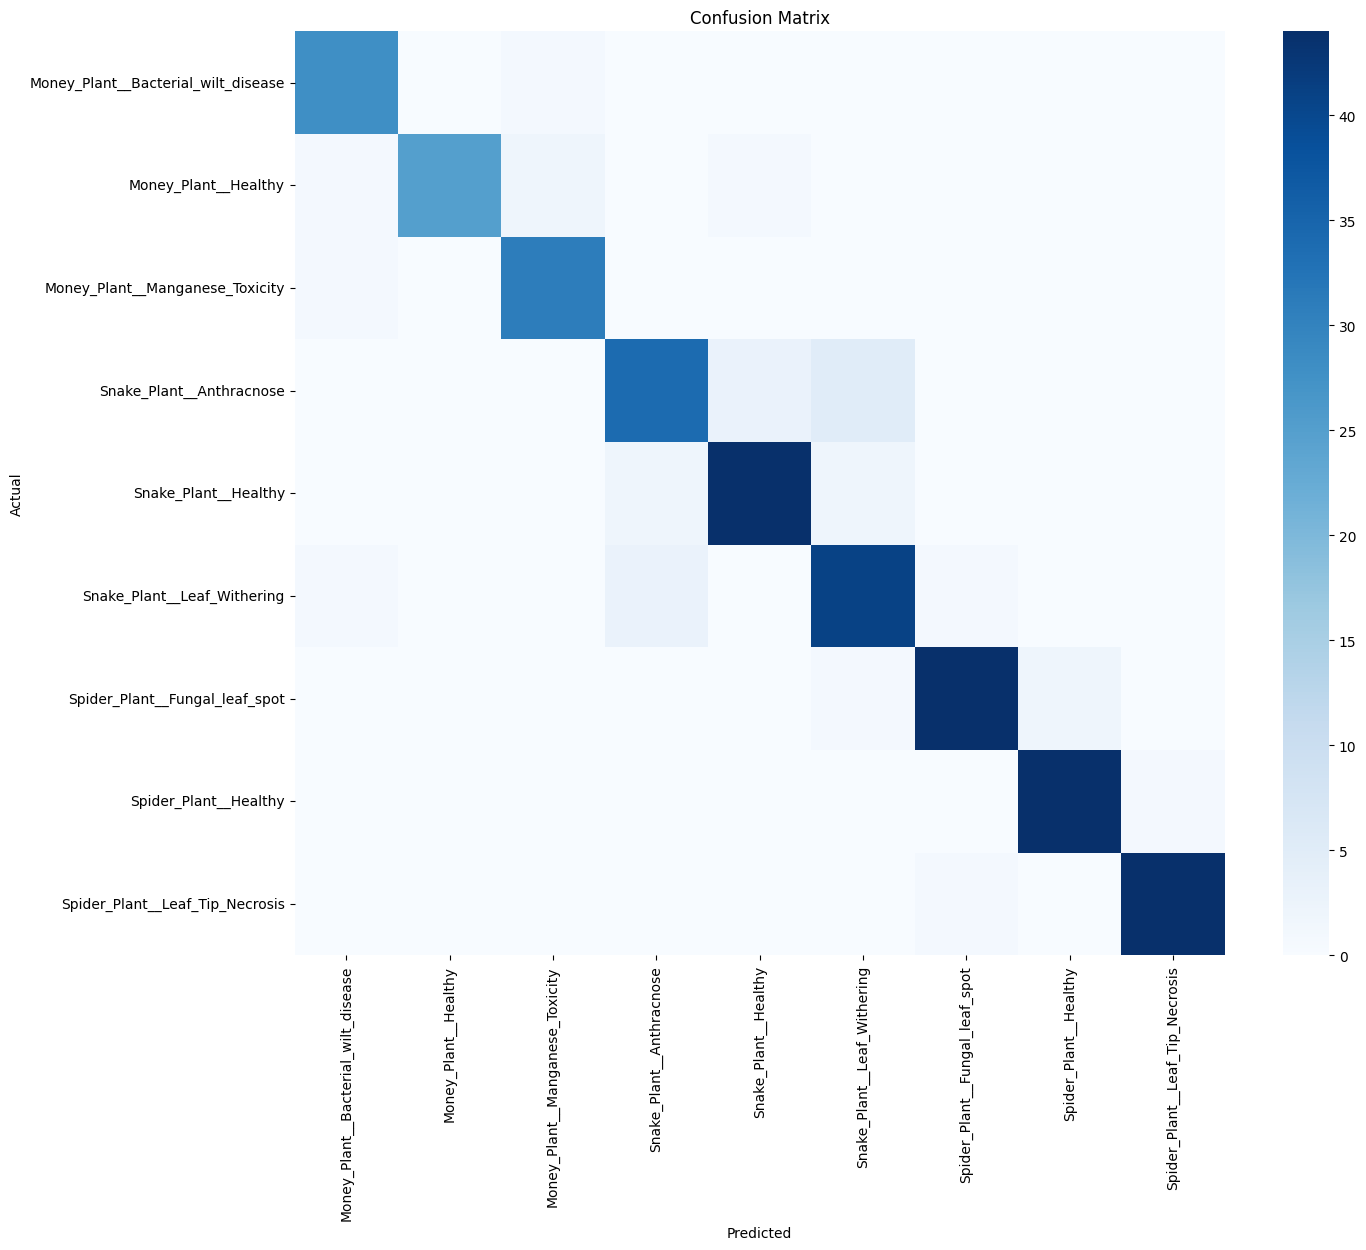

Generating Rogues Gallery (Visualizing Failures)...


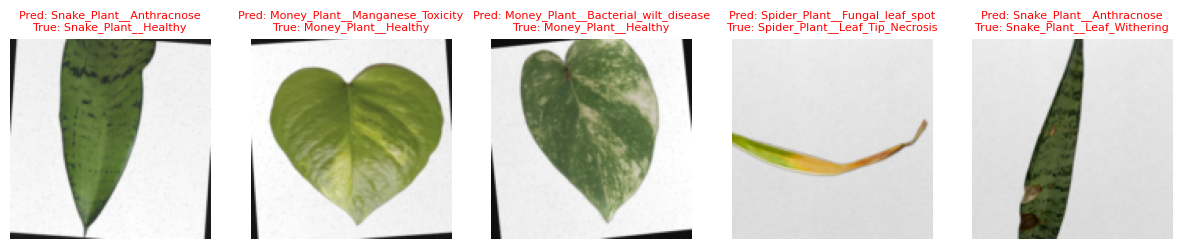

In [9]:
# ==========================================
# BLOCK 10: VISUALIZATION & EVALUATION
# ==========================================
def plot_confusion_matrix(model, loader, classes):
    y_pred = []
    y_true = []
    model.eval()

    print("Generating Confusion Matrix... (This might take a moment)")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Calculate Matrix
    # labels=range(len(classes)) fixes the error if a class is missing in val set
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

    # Plot
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

def rogues_gallery(model, loader, classes):
    print("Generating Rogues Gallery (Visualizing Failures)...")
    model.eval()
    failures = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find errors in this batch
            wrong_idx = (preds != labels).nonzero()
            for idx in wrong_idx:
                if len(failures) < 5:
                    idx = idx.item()
                    failures.append((inputs[idx].cpu(), preds[idx].item(), labels[idx].item()))
            if len(failures) >= 5: break

    # Plot 5 failures
    plt.figure(figsize=(15, 5))
    for i, (img, pred, act) in enumerate(failures):
        # Un-normalize for display
        img = img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {classes[pred]}\nTrue: {classes[act]}", color='red', fontsize=8)
        plt.axis('off')
    plt.show()

# Run Visualization on the Best Model (ResNet)
plot_confusion_matrix(model_3, val_loader, class_names)
rogues_gallery(model_3, val_loader, class_names)

In [19]:
# ==========================================
# BLOCK 11: FINAL COMPARISON
# ==========================================
final_results = {
    "Model 1 (Baseline)": history_1['val_acc'][-1],
    "Model 2 (Optimized)": best_acc,
    "Model 3 (ResNet)": history_3['val_acc'][-1]
}

print("\n🏆 FINAL RESULTS 🏆")
print("-" * 40)
print(f"{'Model Name':<25} | {'Accuracy':<10}")
print("-" * 40)
for name, acc in final_results.items():
    print(f"{name:<25} | {acc:.2f}%")
print("-" * 40)


🏆 FINAL RESULTS 🏆
----------------------------------------
Model Name                | Accuracy  
----------------------------------------
Model 1 (Baseline)        | 70.80%
Model 2 (Optimized)       | 74.66%
Model 3 (ResNet)          | 92.56%
----------------------------------------
